In [1]:
import pickle

import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import arviz as az

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample


from models import deconvolution


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

torch.set_default_device(device)


/home/akseli/dippa/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inverse problem 

In [2]:
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = 2*N
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

params = [0, 2.0, 0.2, 1.0, 0]

def problem_system(grid: np.array, params)-> np.array:

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= 0.1:
            output[idx] = params[0]
        elif point <= 0.2:
            output[idx] = params[1]
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.75:
            #output[idx] = params[3]
            output[idx] = 0.3*np.sin(2*np.pi*point*2)+params[3]
        else:
            output[idx] = point*params[4]
    
    return output



## Convolution matrix

In [3]:
model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

#A[0,0] = 0
#A[-1, -1] = 0

## Data Generation

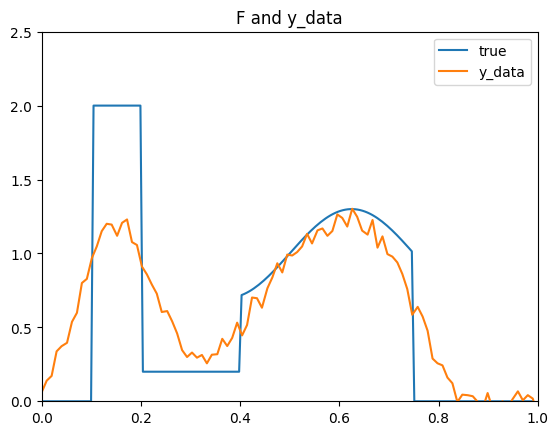

In [4]:
# Generate grid points
x = np.linspace(0, domain[1] - h, n)

# Construct the function f
f = problem_system(x, params)
#f = np.sin(10*x-0.2)
f = A@f
ind = f > 0
f *= ind

# Create y_data with noise
y_data = f + np.random.normal(0, sigma_noise, f.shape)

f = problem_system(x, params)

# Plot f and w
plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='y_data')
plt.axis([domain[0], domain[1], 0, 2.5])
plt.title('F and y_data')
plt.legend()
plt.show()

Old targets

## Pyro BNN

In [5]:
class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.5)).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.5)).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Cauchy(0.,
                                                torch.tensor(0.5)).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05)).expand([h2]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](h1, h2)
        self.fc3.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.5)).expand([h2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05)).expand([h2]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        
        x = x#.reshape(-1, 1)

        mu = self.relu(self.fc1(x))#.squeeze()
        mu = self.relu(self.fc2(mu))
        mu = self.relu(self.fc3(mu))
        #mu = x
        sigma = pyro.sample("sigma", dist.Uniform(0.,
                                                torch.tensor(0.05)))
    
        with pyro.plate("data", 200):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu

In [6]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(t).float().cuda()
y_train = torch.from_numpy(y_data).float().cuda()


## Load BNN model for signals, Prior

In [7]:
bnn_model = BNN(h1=N, h2=n)

In [8]:
predictive = torch.load('../svi_model.pt')

#### Generate prior for the y

In [9]:
prior_bnn = predictive(y_train)

In [10]:
prior_bnn = prior_bnn['obs']
prior_bnn.shape

torch.Size([5000, 200])

#### Plotting the prior

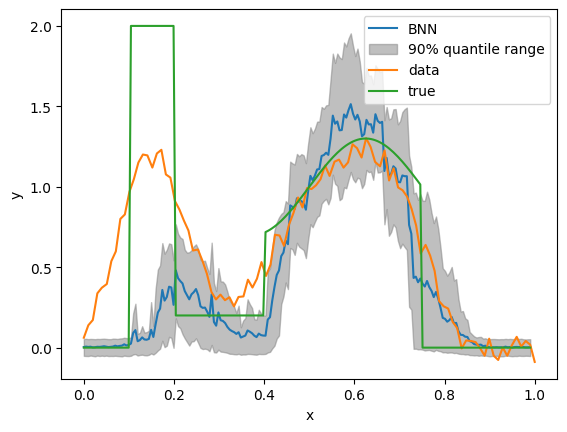

In [11]:
# Calculate mean and quantiles
mean_preds = torch.mean(prior_bnn, axis=0).cpu()
lower_quantile = torch.quantile(prior_bnn, 0.15, axis=0).cpu()
upper_quantile = torch.quantile(prior_bnn, 0.85, axis=0).cpu()

# Plot the mean prediction
plt.plot(x, mean_preds, label='BNN')

# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color='gray', alpha=0.5, label='90% quantile range')

# Plot the true data and the true function
plt.plot(t, y_data, label='data')
plt.plot(x, f, label='true')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()


## Sampling with NUTS

It is not working yet, I can't seem to sample the prior correctly. Have asked Pyro forum for help. 

The code works with just using a Gaussian prior. 

In [12]:
A.shape

(100, 200)

In [16]:
import pyro
import pyro.distributions as dist
import pyro.infer

from torch.distributions import constraints
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex
from tqdm.auto import trange
from pyro.optim import Adam


predictive = pyro.poutine.block(predictive, hide_all=True)
A = torch.tensor(A, dtype=torch.float32).cuda()    # shape [100, 200]
y_data = torch.tensor(y_data, dtype=torch.float32) # shape [100, 1]
f_gpu = torch.tensor(f, dtype=torch.float32) # shape [100, 1]


@infer_discrete(first_available_dim=-4, temperature=0)
@config_enumerate
def inverse_model(A, y_data):

    n = A.size(1)  # Number of features
    prior_samples = pyro.param('prior', prior_bnn.cuda()) # shape [5000, 200]
    
    data_plate = pyro.plate("data_plate", y_data.shape[0], dim=-1)
    feature_plate = pyro.plate("feature_plate", 200, dim=-2)
    component_plate = pyro.plate("component_plate", 5000, dim=-3)
    with feature_plate:
        with component_plate:
            p = pyro.sample("p", dist.Categorical(torch.ones(5000)))

    with component_plate as vdx:
        pc = Vindex(prior_samples)[..., vdx, :]  # Reshape it and use in Vindex.
        mu = torch.matmul(A, pc.T)

        with data_plate:                # Capture plate index.
            x = pyro.sample("x", dist.Normal(mu, 0.05),
                            obs=y_data)

    print(f"    p.shape = {p.shape}")
    print(f"  vdx.shape = {vdx.shape}")
    print(f"    pc.shape = {pc.shape}")
    print(f"    x.shape = {x.shape}")


def guide(A, y_data):
    feature_plate = pyro.plate("feature_plate", 200, dim=-1)
    component_plate = pyro.plate("component_plate", 5000, dim=-2)
    with feature_plate, component_plate:
        pyro.sample("p", dist.Categorical(torch.ones(5000)))

#serving_model = infer_discrete(inverse_model, first_available_dim=-1)
#omega = serving_model(A, y_data)

adam_params = {"lr": 0.0005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(inverse_model, guide, optimizer, loss=TraceEnum_ELBO())

num_iterations = 20
progress_bar = trange(num_iterations)

for j in progress_bar:

    loss = svi.step(A, y_data)
    progress_bar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss))


/home/akseli/dippa/.venv/lib/python3.10/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


ValueError: cannot use plate component_plate as both vectorized and non-vectorizedindependence context
       Trace Shapes:                       
        Param Sites:                       
               prior               5000 200
       Sample Sites:                       
     data_plate dist                      |
               value                100   |
  feature_plate dist                      |
               value                200   |
component_plate dist                      |
               value               5000   |
              p dist      5000 200    1   |
               value 5000    1   1    1   |
Trace Shapes:
 Param Sites:
Sample Sites:

In [27]:
predictive = pyro.infer.Predictive(inverse_model, guide=guide, num_samples=50,
                        return_sites=["_RETURN"])

preds_gpu = predictive(A, y_data)

In [28]:
omega = preds_gpu["_RETURN"]#.squeeze(0)

In [29]:
omega.shape

torch.Size([50, 200])

In [30]:
preds_inverse = preds_gpu['obs']

KeyError: 'obs'

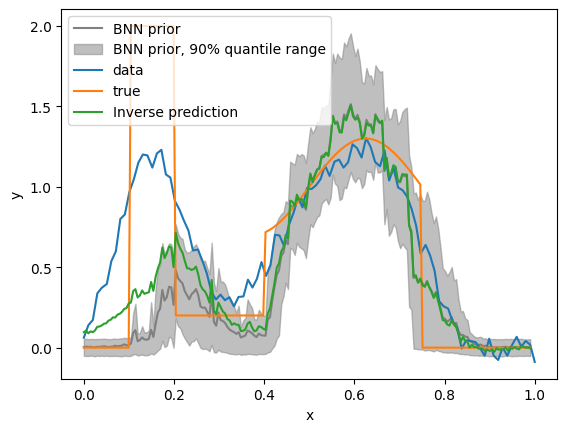

In [31]:
plt.plot(x, mean_preds, color='gray', label='BNN prior')
# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color='gray', alpha=0.5, label='BNN prior, 90% quantile range')

# Plot the true data and the true function
plt.plot(t, y_data.cpu(), label='data')
plt.plot(x, f, label='true')

#plt.plot(t, torch.mean(preds_inverse.cpu(), axis=0), label='Inverse prediction')
plt.plot(x, torch.mean(omega.detach().cpu(), axis=0), label='Inverse prediction')
# Plot the mean prediction



# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()